In [1]:
# Preamble (system)
import sys
import os

if sys.version_info[0] < 3:
  raise AssertionError('Please run this notebook with Python 3.')

In [2]:
# Preamble (EMTF)
import numpy as np

from emtf_algos import *
from emtf_logger import get_logger
from emtf_colormap import get_colormap

# Preamble (notebook)
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import collections
import functools
import itertools
import toolz

In [3]:
# Preamble (ML)
np.random.seed(2027)  # set random seed

import tensorflow as tf
tf.random.set_seed(2027)  # set random seed

#import numba
#from numba import njit, vectorize
import dask
import dask.array as da

try:
  import emtf_nnet
except:
  raise ImportError('This notebook requires emtf_nnet. It can be found at '
                    'https://github.com/jiafulow/emtf-nnet')

logger = get_logger()
logger.info('Using cmssw      : {}'.format(os.environ.get('CMSSW_VERSION', 'n/a')))
logger.info('Using python     : {}'.format(sys.version.replace('\n', '')))
logger.info('Using numpy      : {}'.format(np.__version__))
logger.info('Using matplotlib : {}'.format(matplotlib.__version__))
logger.info('Using tensorflow : {}'.format(tf.__version__))
logger.info('Using keras      : {}'.format(tf.keras.__version__))
logger.info('.. list devices  : {}'.format(tf.config.list_physical_devices()))
#logger.info('Using numba      : {}'.format(numba.__version__))
logger.info('Using dask       : {}'.format(dask.__version__))
logger.info('Using emtf-nnet  : {}'.format(emtf_nnet.__version__))

[INFO    ] Using cmssw      : CMSSW_10_6_3
[INFO    ] Using python     : 3.6.10 |Anaconda, Inc.| (default, Mar 25 2020, 23:51:54) [GCC 7.3.0]
[INFO    ] Using numpy      : 1.19.5
[INFO    ] Using matplotlib : 3.3.2
[INFO    ] Using tensorflow : 2.4.1
[INFO    ] Using keras      : 2.4.0
[INFO    ] .. list devices  : [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
[INFO    ] Using dask       : 2021.01.1
[INFO    ] Using emtf-nnet  : 0.0.1


In [4]:
# Settings

# zone: (0,1,2) -> eta=(1.98..2.5, 1.55..1.98, 1.2..1.55)
zone = 0
#zone = 1
#zone = 2

# timezone: (0,1,2) -> BX=(0,-1,-2)
timezone = 0

#maxevents = 100
maxevents = -1

#workers = 1
workers = 8

# Input files
signal_fname = 'signal_add.20210112.npz'
signal_displ_fname = 'signal_displ_add.20210112.npz'
bkgnd_fname = 'bkgnd_add.20200716.npz'

patterns_fname = 'patterns_zone%i.npz' % zone
quant_nnet_model_fname = 'quant_nnet_model.json'


# Scheduler
dask.config.set(scheduler='threads', num_workers=workers)

# Styling
plt.style.use('tdrstyle.mplstyle')
cm = get_colormap()

logger.info('Processing zone {} timezone {}'.format(zone, timezone))
logger.info('.. maxevents        : {}'.format(maxevents))
logger.info('.. workers          : {}'.format(workers))

[INFO    ] Processing zone 0 timezone 0
[INFO    ] .. maxevents        : -1
[INFO    ] .. workers          : 8


### Load data

In [5]:
def load_signal():
  logger.info('Loading from {0}'.format(signal_fname))
  with np.load(signal_fname) as loaded:
    out_part = loaded['out_part']
    out_hits_values = loaded['out_hits_values']
    out_hits_row_splits = loaded['out_hits_row_splits']
    out_hits_shape = (out_hits_row_splits.shape[0] - 1,) + (None,) + out_hits_values.shape[1:]
    out_simhits_values = loaded['out_simhits_values']
    out_simhits_row_splits = loaded['out_simhits_row_splits']
    out_simhits_shape = (out_simhits_row_splits.shape[0] - 1,) + (None,) + out_simhits_values.shape[1:]
    logger.info('out_part: {} out_hits: {} out_simhits: {}'.format(
        out_part.shape, out_hits_shape, out_simhits_shape))
  return (out_part, (out_hits_values, out_hits_row_splits), (out_simhits_values, out_simhits_row_splits))


def load_bkgnd():
  logger.info('Loading from {0}'.format(bkgnd_fname))
  with np.load(bkgnd_fname) as loaded:
    out_bkg_aux = loaded['out_aux']
    out_bkg_hits_values = loaded['out_hits_values']
    out_bkg_hits_row_splits = loaded['out_hits_row_splits']
    out_bkg_hits_shape = (out_bkg_hits_row_splits.shape[0] - 1,) + (None,) + out_bkg_hits_values.shape[1:]
    logger.info('out_bkg_aux: {} out_bkg_hits: {}'.format(out_bkg_aux.shape, out_bkg_hits_shape))
  return (out_bkg_aux, (out_bkg_hits_values, out_bkg_hits_row_splits))

In [6]:
# Load signal, bkgnd
out_part, out_hits, out_simhits = load_signal()

#out_bkg_aux, out_bkg_hits = load_bkgnd()

[INFO    ] Loading from signal_add.20210112.npz
[INFO    ] out_part: (2000000, 9) out_hits: (2000000, None, 18) out_simhits: (2000000, None, 18)


In [7]:
class PatternHelper(object):
  """Reshapes patterns for use in NN."""
  def get_reshaped_patterns(self, patterns):
    patterns = patterns[3]  # prompt patterns only
    patterns = patterns[[3, 2, 4, 1, 5, 0, 6]]  # ordered by straightness
    return patterns  # shape is (7, 8, 3)

  def get_reshaped_patt_filters(self, patt_filters):
    patt_filters = patt_filters[3]  # prompt patterns only
    patt_filters = patt_filters[[3, 2, 4, 1, 5, 0, 6]]  # ordered by straightness
    patt_filters = np.transpose(patt_filters, [3, 2, 1, 0])  # kernel shape is HWCD
    return patt_filters  # shape is (1, 111, 8, 7)

  def get_reshaped_patt_brightness(self, patt_brightness):
    patt_brightness = patt_brightness // 4  # from 8-bit to 6-bit
    assert patt_brightness.max() == 63
    return patt_brightness  # shape is (256,)


def load_patterns():
  helper = PatternHelper()

  patterns = []
  patt_filters = []
  patt_brightness = []
  for z in range(num_emtf_zones):
    fname = patterns_fname.replace('zone%i' % zone, 'zone%i' % z)  # modify filename
    logger.info('Loading from {}'.format(fname))
    with np.load(fname) as loaded:
      patterns.append(helper.get_reshaped_patterns(loaded['patterns']))
      patt_filters.append(helper.get_reshaped_patt_filters(loaded['boxes_act']))
      patt_brightness.append(helper.get_reshaped_patt_brightness(loaded['hitmap_quality_ranks']))

  patterns = np.asarray(patterns)
  patt_filters = np.asarray(patt_filters)
  patt_brightness = np.asarray(patt_brightness)
  logger.info('patterns: {} patt_filters: {} patt_brightness: {}'.format(
      patterns.shape, patt_filters.shape, patt_brightness.shape))

  pattern_bank = emtf_nnet.keras.utils.PatternBank(
    patterns=patterns, patt_filters=patt_filters, patt_brightness=patt_brightness)
  emtf_nnet.keras.utils.save_pattern_bank(pattern_bank)  # write to file
  loaded_pattern_bank = emtf_nnet.keras.utils.load_pattern_bank(pattern_bank.name + '.json')  # load file
  return loaded_pattern_bank


def load_nnet_model():
  from emtf_nnet.keras.quantization import default_quantize_scheme
  path = quant_nnet_model_fname
  w_path = path.replace('.json', '_weights.h5')
  custom_objects = default_quantize_scheme.DefaultQuantizeScheme._QUANTIZATION_OBJECTS
  logger.info('Loading from {}'.format(path))
  loaded_nnet_model = emtf_nnet.keras.utils.load_nnet_model(path, w_path, custom_objects)
  loaded_nnet_model.trainable = False
  logger.info('NN model: {}'.format(loaded_nnet_model.name))

  # Make sure all the tensors are computed
  input_shape = loaded_nnet_model.inputs[0].shape
  _ = loaded_nnet_model(np.random.random_sample((1,) + input_shape[1:]))
  # Dump weights
  weights = [
    loaded_nnet_model.get_layer('quant_preprocessing').layer.scale.numpy() * np.power(2., 10),  #FIXME: hardcoded quantizer
    np.zeros(loaded_nnet_model.inputs[0].shape[-1], dtype=np.float32),
    loaded_nnet_model.get_layer('quant_dense').layer.folded_kernel.numpy() * np.power(2., 6),
    loaded_nnet_model.get_layer('quant_dense').layer.folded_bias.numpy() * np.power(2., 6),
    loaded_nnet_model.get_layer('quant_dense_1').layer.folded_kernel.numpy() * np.power(2., 6),
    loaded_nnet_model.get_layer('quant_dense_1').layer.folded_bias.numpy() * np.power(2., 6),
    loaded_nnet_model.get_layer('quant_dense_2').layer.folded_kernel.numpy() * np.power(2., 6),
    loaded_nnet_model.get_layer('quant_dense_2').layer.folded_bias.numpy() * np.power(2., 6),
    loaded_nnet_model.get_layer('quant_dense_final').layer.folded_kernel.numpy().squeeze() * np.power(2., 9),
    np.zeros(loaded_nnet_model.outputs[0].shape[-1], dtype=np.float32),
  ]
  emtf_nnet.keras.utils.save_serializable_object(weights, 'nnet_weights.json')  # write to file
  return loaded_nnet_model

In [8]:
# Load pattern bank, NN model
loaded_pattern_bank = load_patterns()

loaded_nnet_model = load_nnet_model()

[INFO    ] Loading from patterns_zone0.npz
[INFO    ] Loading from patterns_zone1.npz
[INFO    ] Loading from patterns_zone2.npz
[INFO    ] patterns: (3, 7, 8, 3) patt_filters: (3, 1, 111, 8, 7) patt_brightness: (3, 256)
[INFO    ] Loading from quant_nnet_model.json
[INFO    ] NN model: quant_nnet_model


### Create inputs

In [9]:
# Configure
from emtf_nnet.architecture import endless_v3

tf.config.optimizer.set_jit(True)  # enable XLA
#tf.config.threading.set_inter_op_parallelism_threads(32)
#tf.config.threading.set_intra_op_parallelism_threads(32)

endless_v3.set_pattern_bank(loaded_pattern_bank)
endless_v3.set_nnet_model(loaded_nnet_model)
config = endless_v3.configure()
endless_v3.set_config(config)

In [10]:
# Create inputs
def get_ragged_tensor(x):
  return emtf_nnet.ragged.RaggedTensorValue(values=x[0], row_splits=x[1])

zone_part, zone_hits, zone_simhits = endless_v3.create_zone_hits(out_part, out_hits, out_simhits)

logger.info('out_part: {} out_hits: {} out_simhits: {}'.format(
    zone_part.shape, get_ragged_tensor(zone_hits).shape, get_ragged_tensor(zone_simhits).shape))

[INFO    ] out_part: (1804493, 9) out_hits: (1804493, None, 18) out_simhits: (1804493, None, 18)


In [11]:
batch_size = 1024

datagen_sparse = endless_v3.get_datagen_sparse(zone_hits, batch_size=batch_size)
try:
  x_test_sparse = datagen_sparse[0]
except:
  raise ValueError('Fail to get data from datagen_sparse.')

datagen = endless_v3.get_datagen(zone_hits, batch_size=batch_size)
try:
  x_test = datagen[0]
except:
  raise ValueError('Fail to get data from datagen.')

assert isinstance(x_test_sparse, list) and len(x_test_sparse) == batch_size
assert isinstance(x_test, np.ndarray) and len(x_test) == batch_size and x_test.ndim == 4

In [12]:
# Debug
my_array2string = functools.partial(
    np.array2string, separator=', ', max_line_width=100, formatter={'int': (lambda x: '% 4d' % x)})

print(my_array2string(x_test_sparse[0]))
print(my_array2string(x_test_sparse[2]))
print(my_array2string(x_test_sparse[13]))

[[   2,    0,  2548,    5,   18,   17,    6,    6,    0,    4,    4,    0,    0,    0,    1],
 [  19,    0,  2684,    2,   16,   16,    6,    6,    0,    4,    4,    1,    0,    0,    1],
 [  28,    0,  2819,   15,   17,   16,    5,    5,    0,    4,    4,    0,    0,    0,    1],
 [  28,    1,  2728,    0,   16,   17,    5,    5,    0,    4,    4,    0,    0,    0,    1],
 [  37,    0,  2736,    0,   16,   16,    5,    5,    0,    4,    4,    0,    0,    0,    1],
 [  55,    0,  2505,    0,   18,   18,    2,    2,    0,    4,    4,    1,    0,    0,    1],
 [  73,    0,  2675,    0,   19,   19,    2,    2,    0,    4,    4,    1,    0,    0,    1],
 [  82,    0,  2888,    0,   17,   17,    1,    1,    1,    4,    4,    0,    0,    0,    1],
 [  82,    1,  2714,    0,   17,   17,    5,    5,    1,    4,    4,    0,    0,    0,    1],
 [  91,    0,  2737,    0,   17,   17,    1,    1,    0,    4,    4,    0,    0,    0,    1],
 [ 109,    0,  2479,   15,   17,   17,    6,    6,    0,    

In [13]:
# Debug
isvalid = lambda x: (x[..., -1] != 0)  # x[..., -1] is the valid flag

print(x_test.shape)
print(my_array2string(x_test[0][isvalid(x_test[0])]))
print(my_array2string(x_test[2][isvalid(x_test[2])]))
print(my_array2string(x_test[13][isvalid(x_test[13])]))

(1024, 115, 2, 13)
[[ 2548,    5,   18,   17,    6,    6,    0,    4,    4,    0,    0,    0,    1],
 [ 2684,    2,   16,   16,    6,    6,    0,    4,    4,    1,    0,    0,    1],
 [ 2819,   15,   17,   16,    5,    5,    0,    4,    4,    0,    0,    0,    1],
 [ 2728,    0,   16,   17,    5,    5,    0,    4,    4,    0,    0,    0,    1],
 [ 2736,    0,   16,   16,    5,    5,    0,    4,    4,    0,    0,    0,    1],
 [ 2505,    0,   18,   18,    2,    2,    0,    4,    4,    1,    0,    0,    1],
 [ 2675,    0,   19,   19,    2,    2,    0,    4,    4,    1,    0,    0,    1],
 [ 2888,    0,   17,   17,    1,    1,    1,    4,    4,    0,    0,    0,    1],
 [ 2714,    0,   17,   17,    5,    5,    1,    4,    4,    0,    0,    0,    1],
 [ 2737,    0,   17,   17,    1,    1,    0,    4,    4,    0,    0,    0,    1],
 [ 2479,   15,   17,   17,    6,    6,    0,    4,    4,    1,    0,    0,    1]]
[[ 4643,    0,   12,   12,    4,    4,    0,    4,    4,    1,    0,    0,    1

### Create model

In [14]:
# Create model
model = endless_v3.create_model()
model.summary()

Model: "endless_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 115, 2, 13)] 0                                            
__________________________________________________________________________________________________
zoning_0 (Zoning)               (None, 8, 288, 1)    0           inputs[0][0]                     
__________________________________________________________________________________________________
zoning_1 (Zoning)               (None, 8, 288, 1)    0           inputs[0][0]                     
__________________________________________________________________________________________________
zoning_2 (Zoning)               (None, 8, 288, 1)    0           inputs[0][0]                     
_________________________________________________________________________________________

In [15]:
# Make predictions
num_test_samples = x_test.shape[0] if maxevents == -1 else maxevents
x_test_1 = x_test[:num_test_samples]
x_test_sparse_1 = x_test_sparse[:num_test_samples]

outputs = model.predict(x_test_1, workers=workers, use_multiprocessing=False)  # now wait...
if isinstance(outputs, tuple):
  for i in range(len(outputs)):
    logger.info('outputs: {} dtype: {}'.format(outputs[i].shape, outputs[i].dtype))
else:
  logger.info('outputs: {} dtype: {}'.format(outputs.shape, outputs.dtype))

[INFO    ] outputs: (1024, 4, 40) dtype: int32
[INFO    ] outputs: (1024, 4, 12) dtype: int32
[INFO    ] outputs: (1024, 4, 1) dtype: bool
[INFO    ] outputs: (1024, 4, 1) dtype: float32


In [16]:
# Debug
print(outputs)

(array([[[  -116, 999999,     20, ...,     16,     63,      0],
        [999999, 999999, 999999, ..., 999999, 999999, 999999],
        [999999, 999999, 999999, ..., 999999, 999999, 999999],
        [999999, 999999, 999999, ..., 999999, 999999, 999999]],

       [[  -251, 999999,     -3, ...,      7,     61,      0],
        [999999, 999999, 999999, ..., 999999, 999999, 999999],
        [999999, 999999, 999999, ..., 999999, 999999, 999999],
        [999999, 999999, 999999, ..., 999999, 999999, 999999]],

       [[   123, 999999,      8, ...,     11,     63,      0],
        [999999, 999999, 999999, ..., 999999, 999999, 999999],
        [999999, 999999, 999999, ..., 999999, 999999, 999999],
        [999999, 999999, 999999, ..., 999999, 999999, 999999]],

       ...,

       [[999999, 999999,     20, ...,     87,     34,      0],
        [999999, 999999, 999999, ..., 999999,      0,      0],
        [999999, 999999, 999999, ..., 999999,      0,      0],
        [999999, 999999, 999999, ..

In [17]:
# Debug
print(outputs[0][0, 0])
print(outputs[1][0, 0])
print(outputs[0][2, 0])
print(outputs[1][2, 0])
print(outputs[0][13, 0])
print(outputs[1][13, 0])

[  -116 999999     20     64     72 999999 999999     50     73   -159
     11   -185      1 999999      0      0      0 999999 999999      1
      1      2      3      1      5 999999      2      0      0     15
      6 999999      6      5      5      6    -80     16     63      0]
[  4 230  38  57  74 230 230 165 182 110 146 218]
[   123 999999      8    -17    -35 999999 999999    -37    -37 999999
     27    141      1 999999      0      0      0 999999 999999     -1
      0 999999      1      2      0 999999      0      1     -2     -6
      4 999999      5      5      6      6   1776     11     63      0]
[ 22 230  40  58  76 230 230 166 184 230 148 226]
[   381 999999      8    -41 999999 999999 999999    -46     -9    417
 999999    461      3 999999      1      0 999999 999999 999999      1
      0      4 999999      4    -10 999999     -3      1 999999    -28
      5 999999      4      5 999999      6    240     14     63      0]
[ 19 230  38  56 230 230 230 164 182 126 230 

In [18]:
extractor_layers = [model.get_layer('zonemerging_0').output,
                    model.get_layer('trkbuilding_0').output,
                    model.get_layer('duperemoval_0').output,
                    model.get_layer('trainfilter_0').output,
                    model.get_layer('fullyconnect_0').output,]

extractor = tf.keras.Model(inputs=model.inputs, outputs=extractor_layers)

extracted = extractor.predict(x_test_1, workers=workers, use_multiprocessing=False)  # now wait...
extracted = iter(extracted)
extracted_zonemerging_0 = next(extracted)
extracted_trkbuilding_0 = next(extracted)
extracted_duperemoval_0 = next(extracted)
extracted_trainfilter_0 = next(extracted)[1:]   # drop features array
extracted_fullyconnect_0 = next(extracted)[2:]  # drop features and passed arrays

assert isinstance(extracted_fullyconnect_0, tuple) and (len(extracted_fullyconnect_0) == 1)
extracted_fullyconnect_0 = (extracted_fullyconnect_0[0] * np.power(2., 13),)  #FIXME: hardcoded quantizer

In [19]:
# Make testbench
if maxevents != -1:
  save_serializable_object = emtf_nnet.keras.utils.save_serializable_object

  print(len(x_test_sparse_1))
  print(len(extracted_zonemerging_0), [x.shape for x in extracted_zonemerging_0])
  print(len(extracted_trkbuilding_0), [x.shape for x in extracted_trkbuilding_0])
  print(len(extracted_duperemoval_0), [x.shape for x in extracted_duperemoval_0])
  print(len(extracted_trainfilter_0), [x.shape for x in extracted_trainfilter_0])
  print(len(extracted_fullyconnect_0), [x.shape for x in extracted_fullyconnect_0])

  save_serializable_object(x_test_sparse_1, 'x_test_sparse.json')
  save_serializable_object(extracted_zonemerging_0, 'extracted_zonemerging_0.json')
  save_serializable_object(extracted_trkbuilding_0, 'extracted_trkbuilding_0.json')
  save_serializable_object(extracted_duperemoval_0, 'extracted_duperemoval_0.json')
  save_serializable_object(extracted_trainfilter_0, 'extracted_trainfilter_0.json')
  save_serializable_object(extracted_fullyconnect_0, 'extracted_fullyconnect_0.json')

### Evaluate model

In [20]:
%%time

if maxevents == -1:
  outputs = model.predict(datagen, workers=workers, use_multiprocessing=False)  # now wait...
  if isinstance(outputs, tuple):
    for i in range(len(outputs)):
      logger.info('outputs: {} dtype: {}'.format(outputs[i].shape, outputs[i].dtype))
  else:
    logger.info('outputs: {} dtype: {}'.format(outputs.shape, outputs.dtype))

[INFO    ] outputs: (1804493, 4, 40) dtype: int32
[INFO    ] outputs: (1804493, 4, 12) dtype: int32
[INFO    ] outputs: (1804493, 4, 1) dtype: bool
[INFO    ] outputs: (1804493, 4, 1) dtype: float32


CPU times: user 1h 33min 7s, sys: 13min 58s, total: 1h 47min 5s
Wall time: 16min 10s


In [21]:
# Create features and truths for training
if maxevents == -1:
  features = outputs[0][:, 0, :]
  truths = zone_part
  passed = outputs[2][:, 0, 0]

  features, truths = (x[passed] for x in (features, truths))
  logger.info('features: {0} dtype: {1}'.format(features.shape, features.dtype))
  logger.info('truths: {0} dtype: {1}'.format(truths.shape, truths.dtype))

[INFO    ] features: (1605694, 40) dtype: int32
[INFO    ] truths: (1605694, 9) dtype: float32


In [22]:
def latticeplot():
  fig, axs = plt.subplots(ni, nj, figsize=(6,6*ni/nj))
  for i in range(ni):
    for j in range(nj):
      ij = (i * nj) + j
      if ij >= xdata.shape[1]:
        break
      #
      if axs.ndim == 2:
        ax = axs[i, j]
      elif axs.ndim == 1:
        ax = axs[j]
      else:
        ax = axs
      ax.hist(xdata[:, ij][xmask[:, ij]])
      ax.set_xticklabels([])
      ax.set_yticklabels([])
  plt.show()

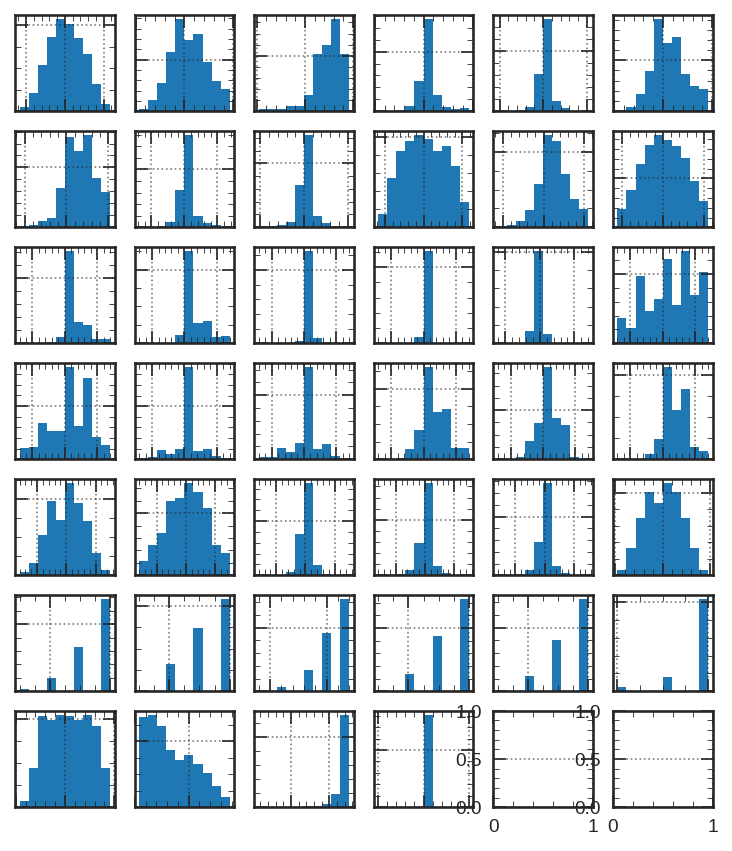

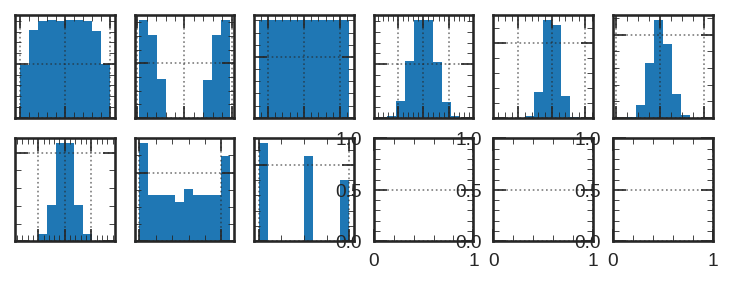

In [23]:
# Plot features and truths
if maxevents == -1:
  ni, nj = 7, 6
  xdata = features
  xmask = (features != ma_fill_value())
  latticeplot()
  #
  ni, nj = 2, 6
  xdata = truths
  xmask = np.isfinite(truths)
  latticeplot()

In [24]:
# Write to file
if maxevents == -1:
  outfile = 'features.h5'
  outdict = {'features': da.from_array(features), 'truths': da.from_array(truths)}
  da.to_hdf5(outfile, outdict, compression='lzf')
  logger.info('Wrote to {}'.format(outfile))

[INFO    ] Wrote to features.h5
